# Upward inference
In this jupyter notebook we will show simple example upward inference in [Logical Neural Networks](https://github.com/IBM/LNN) (LNN).

Before we introduce upward inference we will define our model, [predicates](https://en.wikipedia.org/wiki/Predicate_%28mathematical_logic%29) and [axioms](https://en.wikipedia.org/wiki/Axiom) which will be later used for infering.

We will try to model simple example. Lets define it in natural language:

> Some *grecians* are *humans*. *Zeus* is grecian and it is not a human. *Socrates* is grecian and it is a human. *Confucius* is not grecian and it is a human. *Great Pyramid of Giza* is not grecian and it is not a human.

This is called *background knowledge*. We can express the first sentence as [First-order logic](https://en.wikipedia.org/wiki/First-order_logic) [axiom]((https://en.wikipedia.org/wiki/Axiom)):

> $(\exists x)(grecian(x) \implies human(x))$

Now express this knowledge in LNN model.

In [1]:
from lnn import Model

# create empty model
model = Model()

Define predicates, for our example two predicates will be needed $grecian(x)$ and $human(x)$.

In [2]:
from lnn import Predicate

# define our two predicates (with arity 1 - which is default) and name them accordingly
# represents that entity is a grecian
grecian = Predicate(name="grecian")
# represents that entity is a human
human = Predicate(name="human")

# add predicates to the model
model.add_formulae(grecian, human)

Define and insert our axiom to the model.

In [3]:
from lnn import Variable, Implies, Exists, World

# free variable is needed for defining our axiom
x = Variable("x")

# define our axiom
some_grecians_are_humans = Exists(
    x,
    Implies(grecian(x), human(x), name="grecians_are_humans"),
    name="some_grecians_are_humans",
    world=World.AXIOM,
)

# add axiom to the model
model.add_formulae(some_grecians_are_humans)


Now, we can check if our model contains all required predicates and axioms. Since model can be expressed as graph which represents syntax tree of our formula we can simply plot it and verify the graph edges.

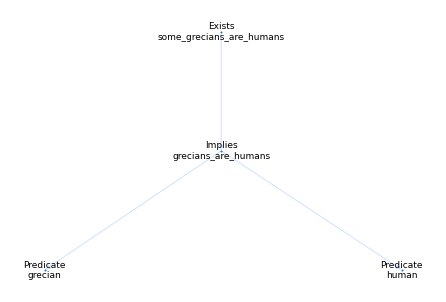

In [4]:
from lnn.utils import plot_graph

plot_graph(model)

Model can be also simply printed.

Do not be confused with variable `x0` it was created automatically for us. The variable `x` was created by us before.

In [5]:
model.print()


***************************************************************************
                                LNN Model

AXIOM  Exists: some_grecians_are_humans (x)                 TRUE (1.0, 1.0)

OPEN   Implies: grecians_are_humans(x) 

OPEN   Predicate: human(x0) 

OPEN   Predicate: grecian(x0) 

***************************************************************************


## Adding facts

Before inference itself, since we will do so called *grounded inference*, we add so called *facts* which will be used in the upward inference.

Remember that we mentioned multiple entities in our example. We can add them as a facts to the predicates.

In [6]:
from lnn import Fact

# add facts to our model
model.add_facts(
    {
        # note that name "grecian" have to match name of the predicate defined before
        "grecian":
        # Fact.TRUE are bounds [1, 1] which represents that Zeus and Socrates are
        # grecian in truth value 1.0
        # Fact.FALSE are bounds [0, 0] which represents that Confucius and Great Pyramid of Giza are
        # grecian in truth value 1.0
        {
            "Zeus": Fact.TRUE,
            "Socrates": Fact.TRUE,
            "Confucius": Fact.FALSE,
            "Great Pyramid of Giza": Fact.FALSE,
        },
        "human": {
            "Zeus": Fact.FALSE,
            "Socrates": Fact.TRUE,
            "Confucius": Fact.TRUE,
            "Great Pyramid of Giza": Fact.FALSE,
        },
    }
)


In [7]:
# note truth bounds on the right side of the table
model.print()


***************************************************************************
                                LNN Model

AXIOM  Exists: some_grecians_are_humans (x)                 TRUE (1.0, 1.0)

OPEN   Implies: grecians_are_humans(x) 

OPEN   Predicate: human(x0) 
'Socrates'                                                  TRUE (1.0, 1.0)
'Great Pyramid of Giza'                                    FALSE (0.0, 0.0)
'Zeus'                                                     FALSE (0.0, 0.0)
'Confucius'                                                 TRUE (1.0, 1.0)

OPEN   Predicate: grecian(x0) 
'Socrates'                                                  TRUE (1.0, 1.0)
'Great Pyramid of Giza'                                    FALSE (0.0, 0.0)
'Zeus'                                                      TRUE (1.0, 1.0)
'Confucius'                                                FALSE (0.0, 0.0)

***************************************************************************


## Inference
Now we have everything ready for so called *upward inference*. The "upward" in the name comes from the direction in which inference go through syntax tree of the formula.

In our case, we will start from atoms (two predicates in our case) and compute truth bounds for each subformula (implication in our case).

Now we will show that upward inference can be used to perform basic logical computations.

In [13]:
from lnn import Direction

# perform inference
steps, facts_inferred = model.infer(direction=Direction.UPWARD)

# result of the inference can be checked, we will see that inference happened in single step and four facts were inferred
steps, facts_inferred

(1, tensor(0., grad_fn=<AddBackward0>))

Recall that truth table of classical [logical implication](https://en.wikipedia.org/wiki/Truth_table#Logical_implication) is as follows:

| $P$     | $Q$     | $P \implies Q$ |
|---------|---------|:--------------:|
| *False* | *False* |     *True*     |
| *False* | *True*  |     *True*     |
| *True*  | *False* |     *False*    |
| *True*  | *True*  |     *True*     |

In our specific case we expect following result:

| $grecian(x)$                    | $human(x)$                      | $grecians\_are\_humans(x)$ |
|---------------------------------|---------------------------------|:--------------------------:|
| Great Pyramid of Giza (*False*) | Great Pyramid of Giza (*False*) |           *False*          |
| Confucius (*False*)             | Confucius (*True*)              |           *False*          |
| Zeus (*True*)                   | Zeus (*False*)                  |           *True*           |
| Socrates (*True*)               | Socrates (*True*)               |           *True*           |

When we print the model, we can verify the result, note the trut bounds on the right under `OPEN   Implies: grecians_are_humans(x)`:

In [12]:
model.print()


***************************************************************************
                                LNN Model

AXIOM  Exists: some_grecians_are_humans (x)                 TRUE (1.0, 1.0)

OPEN   Implies: grecians_are_humans(x) 
'Socrates'                                                  TRUE (1.0, 1.0)
'Zeus'                                                     FALSE (0.0, 0.0)
'Great Pyramid of Giza'                                     TRUE (1.0, 1.0)
'Confucius'                                                 TRUE (1.0, 1.0)

OPEN   Predicate: human(x0) 
'Socrates'                                                  TRUE (1.0, 1.0)
'Great Pyramid of Giza'                                    FALSE (0.0, 0.0)
'Zeus'                                                     FALSE (0.0, 0.0)
'Confucius'                                                 TRUE (1.0, 1.0)

OPEN   Predicate: grecian(x0) 
'Socrates'                                                  TRUE (1.0, 1.0)
'Great Pyramid of